<a href="https://colab.research.google.com/github/nabinyd/60-Days-of-learning/blob/main/09_pytorch_model_deploy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day 52

# 09 PyTorch Model deployment

What is model deployment?

Machine learning model deployment is the act of making your machine learning model(s) available to someone or somthing else.

## 0 Get setup

In [80]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

## setup device agnostic code

In [81]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Getting data

In [82]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


PosixPath('data/pizza_steak_sushi_20_percent')

In [83]:
# Setup directory paths to train and test images
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

In [84]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

## 2 FoodVision Mini model deployment experiment outline

### 3 questions
1. What is my most ideal machine learning model deployment scenario?
2. Where is my model going to?
3. How is my model going to function?

**FoodVision Mini ideal use case:** A model that performs well and fast.

* Performs well: 95%+ accuracy
* Fast: as close to  real-time(or faster)


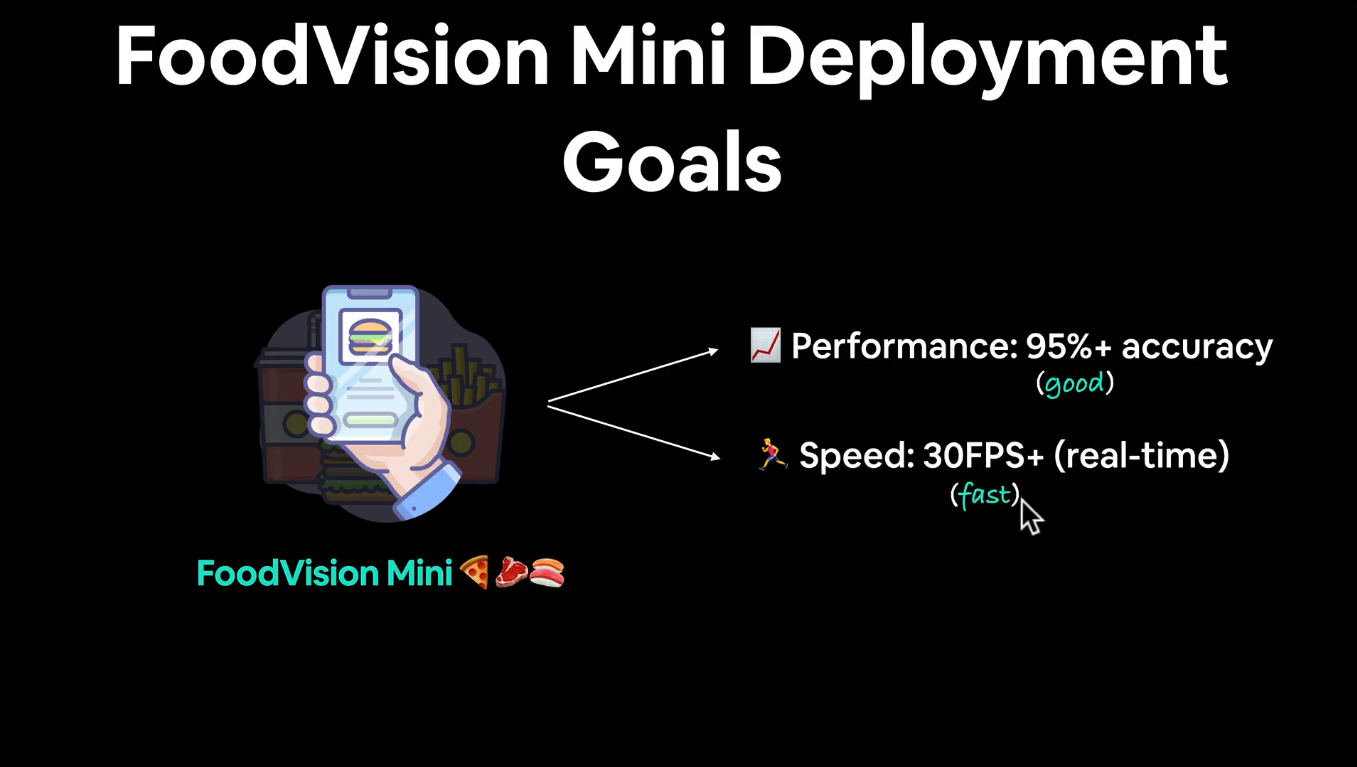

# Day 53

## 3 Creating a EffNetB2 feature extractor

Feature extracktor = a term for a transfer l3earning model that has its base layers frozen and output layers (or head layers) customized to a certain problem.

In [85]:
# 1. Setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# 2. Get EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup pretrained model
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights) # could also use weights="DEFAULT"

# 4. Freeze the base layers in the model (this will freeze all layers to begin with)
for param in effnetb2.parameters():
    param.requires_grad = False

In [86]:
# Check out EffNetB2 classifier head
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [87]:
set_seeds()
# 5. Update the classifier head
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True), # keep dropout layer same
    nn.Linear(in_features=1408, # keep in_features same
              out_features=3)) # change out_features to suit our number of classes

In [88]:
from torchinfo import summary
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 3.1 Creating a function to make an EffNetB2 feature exrtactor

In [89]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

In [90]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

In [91]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [92]:
from torchinfo import summary

# # Print EffNetB2 model summary (uncomment for full output)
# summary(effnetb2,
#         input_size=(1, 3, 224, 224),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

### 3.2 Creating DataLoaders for EffNetB2

In [93]:
# Setup DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

In [94]:
len(train_dataloader_effnetb2)

15

### 3.3 Training EffNetB2 feature extractor

In [95]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Set seeds for reproducibility and train the model
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9839 | train_acc: 0.5667 | test_loss: 0.7393 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7135 | train_acc: 0.8396 | test_loss: 0.5862 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5874 | train_acc: 0.8958 | test_loss: 0.4891 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4488 | train_acc: 0.9146 | test_loss: 0.4338 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4277 | train_acc: 0.9125 | test_loss: 0.3907 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4392 | train_acc: 0.8896 | test_loss: 0.3525 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4246 | train_acc: 0.8771 | test_loss: 0.3263 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3885 | train_acc: 0.8979 | test_loss: 0.3465 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3795 | train_acc: 0.8812 | test_loss: 0.3127 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3752 | train_acc: 0.8688 | test_loss: 0.2811 | test_acc: 0.9625



### 3.4 Inspecting EffNetB2 loss curves

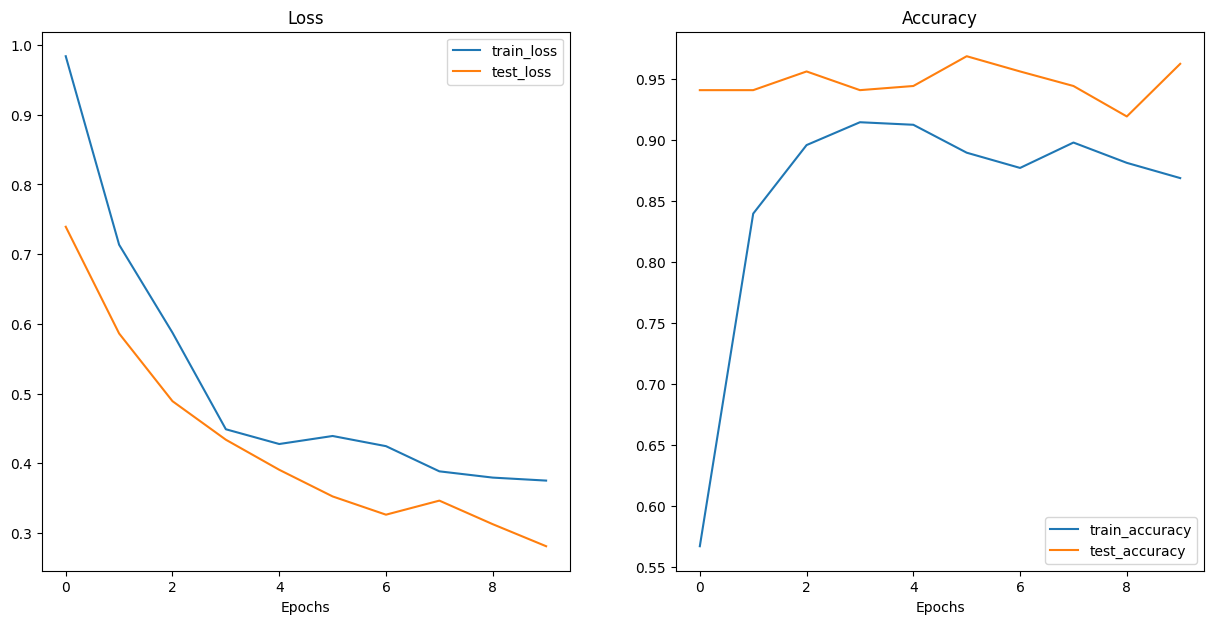

In [96]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

### 3.5 Saving EffNetB2 feature extractor

In [97]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


### 3.6 Checking the size of EffNetB2 feature extractor

Why would it be important to consider the size of a saved model?

If we're deploying our model to be used on a mobile app/website, there may belimited compute resources.

So if our model file is too large, we may not be able to store/ run it on our target device

In [98]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


### 3.7 Collecting EffNetB2 feature extractor stats

In [99]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [100]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.28108686208724976,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

## 4 Creating a ViT feature extractor

In [101]:
# Check out ViT heads layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [102]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.
        seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model.
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes

    return model, transforms

In [103]:
# Create ViT model and transforms
vit, vit_transforms = create_vit_model(num_classes=3,
                                       seed=42)
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [104]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [105]:
from torchinfo import summary

# # Print ViT feature extractor model summary (uncomment for full output)
summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 4.1 Create dataloaders fro ViT feature extractor

In [106]:
# Setup ViT DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

### 4.2 Training ViT feature extractor

In [107]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT model with seeds set for reproducibility
set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


### 4.3 Inspecting ViT loss curves

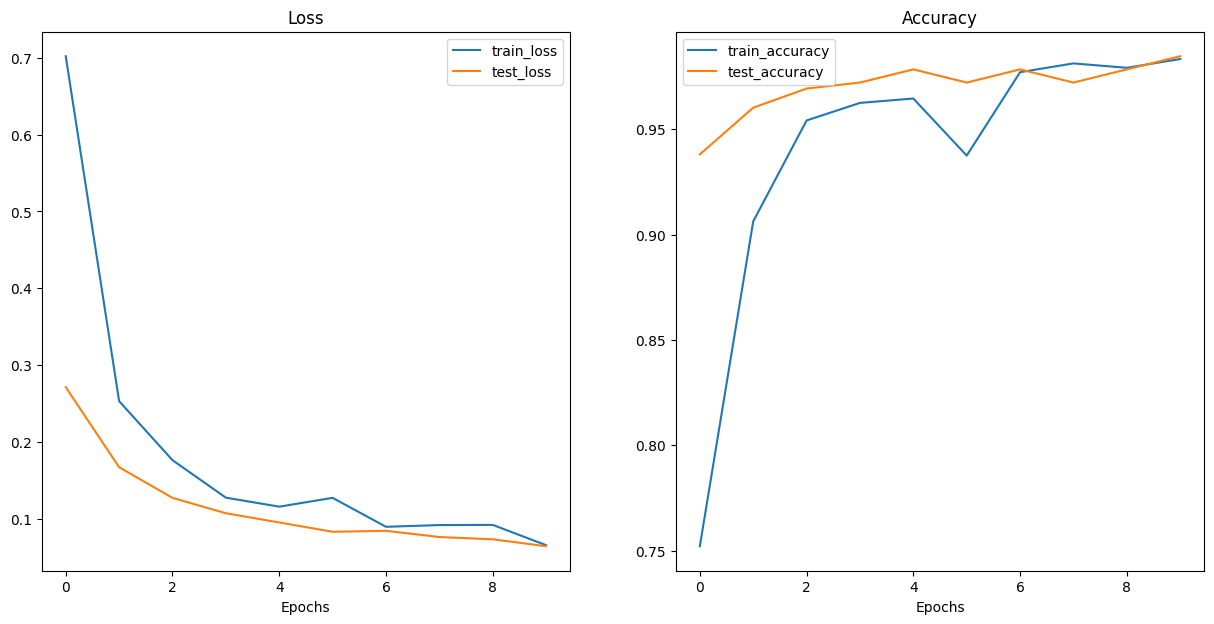

In [108]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

### 4.4 Saving ViT feature extractor

In [109]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


### 4.5 Checking the size of ViT feature extractor

In [110]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


### 4.6 Collecting ViT feature extractor stats

In [111]:
# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [112]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

vit_stats

{'test_loss': 0.06443451717495918,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

# Day 55

## 5. Making predictions with our trained models and timing them


our goal:
1. Performs well (95%+ test accuracy)
2. Fast (30+FPS)

To test criteria two:
1. Loop through test images
2. Tines how long each model takes to make a prediction on the image

Let's work towards making a function called `pred_and_store()` to do so.



In [113]:
from pathlib import Path

# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: data/pizza_steak_sushi_20_percent/test


[PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/511818.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/2743100.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/167716.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/3886015.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/128616.jpg')]

### 5.1 Creating a function tomake across the test dataset

1. Create a function that takes a list of paths, a trained PyTorch model, a series of transforms (to prepare images), a list of target class names and a target device.

2. Create an empty list to store prediction dictionaries (we want the function to return a list of dictionaries, one for each prediction).

3. Loop through the target input paths (steps 4-14 will happen inside the loop).

3. Create an empty dictionary for each iteration in the loop to store prediction values per sample.

4. Get the sample path and ground truth class name (we can do this by infering the class from the path).

5. Start the prediction timer using Python's timeit.default_timer().
6. Open the image using PIL.Image.open(path).
8. Transform the image so it's capable of being used with the target model as well as add a batch dimension and send the image to the target device.
9. Prepare the model for inference by sending it to the target device and turning on eval() mode.
10. Turn on torch.inference_mode() and pass the target transformed image to the model and calculate the prediction probability using torch.softmax() and the target label using torch.argmax().
11. Add the prediction probability and prediction class to the prediction dictionary created in step 4. Also make sure the prediction probability is on the CPU so it can be used with non-GPU libraries such as NumPy and pandas for later inspection.
12. End the prediction timer started in step 6 and add the time to the prediction dictionary created in step 4.
13. See if the predicted class matches the ground truth class from step 5 and add the result to the prediction dictionary created in step 4.
14. Append the updated prediction dictionary to the empty list of predictions created in step 2.
15. Return the list of prediction dictionaries.

In [114]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

    # 2. Create an empty list to store prediction dictionaires
    pred_list = []

    # 3. Loop through target paths
    for path in tqdm(paths):

        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # 6. Start the prediction timer
        start_time = timer()

        # 7. Open image path
        img = Image.open(path)

        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device)

        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()

        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on)
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)

    # 15. Return list of prediction dictionaries
    return pred_list

### 5.2 Making and timing predictions with EffNetB2

In [115]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU

  0%|          | 0/150 [00:00<?, ?it/s]

In [116]:
len(effnetb2_test_pred_dicts)

150

In [117]:
 # Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/sushi/5...,sushi,0.6069,sushi,0.1680,True
1,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.9171,sushi,0.1206,True
2,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.4836,sushi,0.1155,True
3,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,0.9504,sushi,0.1144,True
4,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.9492,sushi,0.1100,True


In [118]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

correct
True     144
False      6
Name: count, dtype: int64

In [119]:
# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")


EffNetB2 average time per prediction: 0.1205 seconds


In [120]:
# Add EffNetB2 average prediction time to stats dictionary
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.28108686208724976,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': 0.1205}

### 5.3 Making and timing predictions with ViT

In [121]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [122]:
# Check the first couple of ViT predictions on the test dataset
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/511818.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.9895,
  'pred_class': 'sushi',
  'time_for_pred': 0.6274,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/2743100.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.9963,
  'pred_class': 'sushi',
  'time_for_pred': 0.4012,
  'correct': True}]

In [123]:
# Turn vit_test_pred_dicts into a DataFrame
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/sushi/5...,sushi,0.9895,sushi,0.6274,True
1,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.9963,sushi,0.4012,True
2,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.6123,sushi,0.3824,True
3,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,0.9441,sushi,0.3782,True
4,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.9876,sushi,0.3989,True


In [124]:
# Count the number of correct predictions
vit_test_pred_df.correct.value_counts()

correct
True     148
False      2
Name: count, dtype: int64

In [125]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

ViT average time per prediction: 0.4574 seconds


In [126]:
# Add average prediction time for ViT model on CPU
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06443451717495918,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': 0.4574}

# Day 56

## 6. Comparing model results, prediction times and size

In [127]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.281087,96.25,7705221,29,0.1205,EffNetB2
1,0.064435,98.47,85800963,327,0.4574,ViT


In [128]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]), # divide ViT statistics by EffNetB2 statistics
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.229233,1.023065,11.135432,11.275862,3.795851


#### 6.1 Visualizing the speed vs. performance tradeoff


We can do so with matplotlib:
1. Create a scatter  plot from the comparison DataFrame to compare EffNetB2 and ViT across test accuracy and prediction time.
2. Add titles and labels to make our plot look nice.
3. Annotate the samples on the scatter plot from step 1 with their appropriate labels (`the model names`).
4. Create a legend based on the model sizes (`model_size (MB)`).

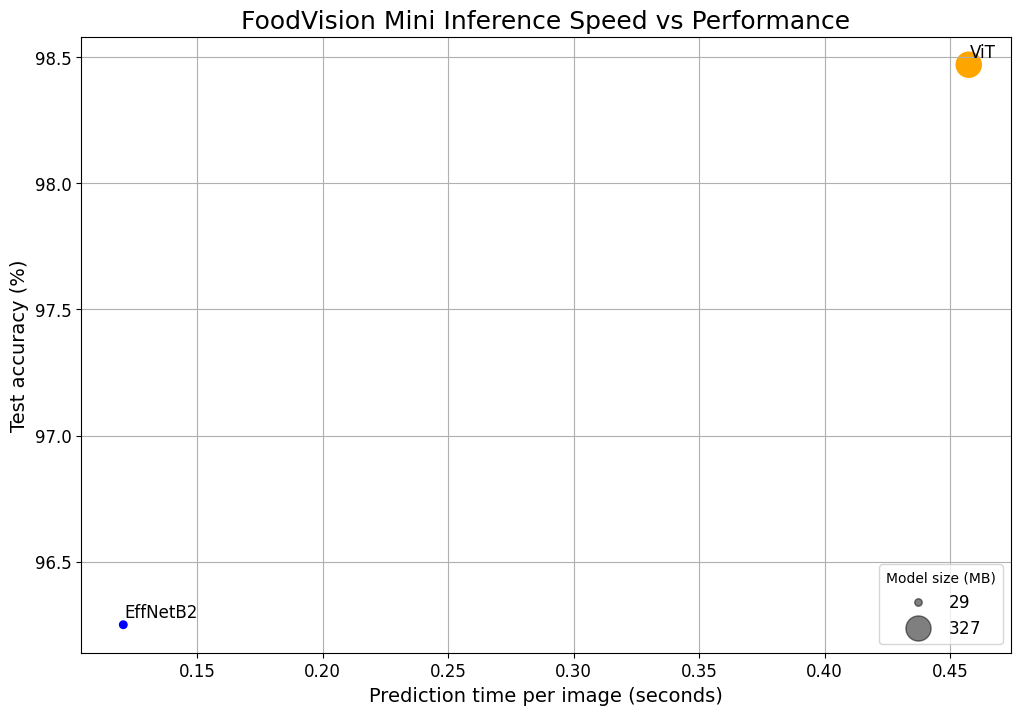

In [129]:
# 1. Create a plot from model comparison DataFrame
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"], # what colours to use?
                     s="model_size (MB)") # size the dots by the model sizes

# 2. Add titles, labels and customize fontsize for aesthetics
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Annotate with model names
for index, row in df.iterrows():
    ax.annotate(text=row["model"], # note: depending on your version of Matplotlib, you may need to use "s=..." or "text=...", see: https://github.com/faustomorales/keras-ocr/issues/183#issuecomment-977733270
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="Model size (MB)",
                              fontsize=12)

# Save the figure
plt.savefig("09-foodvision-mini-inference-speed-vs-performance.jpg")

# Show the figure
plt.show()

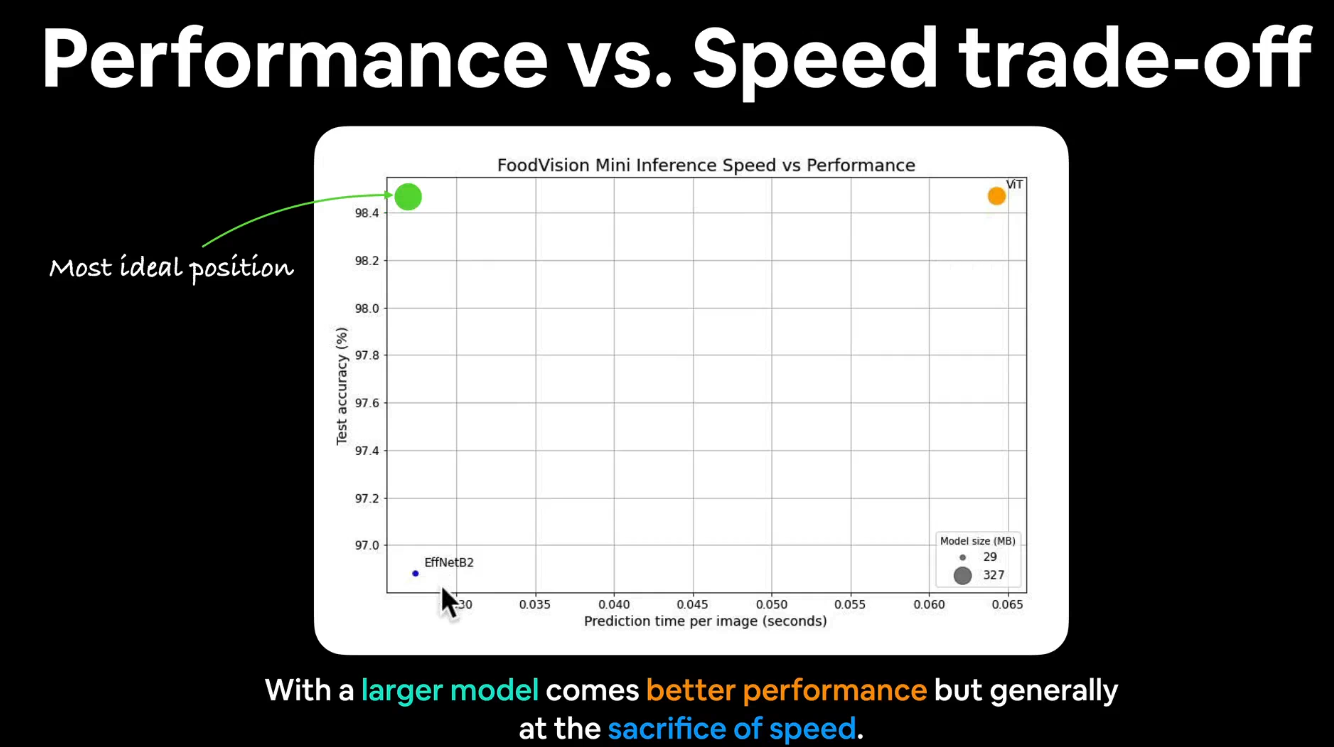

## 7. Bringing FoodVision Mini to life by creating a Gradio demo

###  7.1  Gradio overview

We've chosen to deplow EffNetB2 as it fulfills our criteria the best.

What is Gradio?

Gradio is the fastest way to demo your machine learning model with a friendly web interface so that anyone can use it, anywhere!

Gradio is a python library that simplifies the process of creating interactive user interfaces for machine learning models. It allows developers to quickly build web-based interfaces to demo, test, and interact with their models without needing extensive web development knowledge. Gradio supports a wide variety of input and output types, making it versatile for different appplications.


**Key features of Gradio**

1. **Ease of use**: Gradio provides a simple API to create interfaces, often requiring just a few lines of code.
2. **Variety of Input/Output types**: Supports varios input types such as text, images, audio, video, and more. Outputs can include lables, plots, images, etc
3. **Real time interaction**: Users can interact with models in real-time, making it easier to see how models perform with different inputs.
4. **Sharable Links**: Gradio can generate a shareable link to the interface,  allowing others to test and interact with themodel without needing to run the code locally.
5. **Integration**: Works seamlessly with popular machine learning frameworks like Tensorflow, PyTorch, and Hugging Face Transformers.

In [130]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

Gradio version: 4.39.0


### 7.2 Creating a function to map our inputs and outputs

In [131]:
# Put EffNetB2 on CPU
effnetb2.to("cpu")

# Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

let's create a function called `predict()` to replicate the workflow above.
```
Images of food -> ML Model (EffNetB2) -> outputs (food class label)
```

In [132]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

In [133]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/steak/2246332.jpg

Prediction label and probability dictionary: 
{'pizza': 0.03838454931974411, 'steak': 0.9341026544570923, 'sushi': 0.027512820437550545}
Prediction time: 0.12253 seconds


### 7.3 Creating a list of example images

In [134]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/pizza/296426.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/2901001.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/2117351.jpg']]

### 7.4 Building a Gradio interface

```
input: image -> transform -> predict with EffNetB2 -> output: pred, pred prob, time
```

In [135]:
import gradio as gr

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created By Nabin Yadav"

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
# demo.launch(debug=False, # print errors locally?
 #           share=True) # generate a publically shareable URL?

# Day 57

## 8. Turning our FoodVision Mini Gradio Demo into a deployable app

### 8.1 What is Hugging Face Spaces?

Hugging Face Spaces offer a simple way to host ML directly on your profile or your organization's profile. This allows you to create your ML protfolio, showcase your projects at conferences or to stakeholders, and work collaboratively withother people in the ML ecosystem.

If GitHub is a place to show your coding ability, Hugging Face Spaces is a place to show your machine learning ability (through sharing ML demos that you've built)


### 8.2 Deployed Gradio app structure

Let's start to put all of our app files into a single directory:

```
Colab -> folder with gradio files -> upload app files to Hugging Face Spaces -> deploy
```

By the end our file structure will look like

```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
  ```

### 8.3 Creating a demos folder to store our FoodVision Mini app files

In [136]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
foodvision_mini_demo_path = Path("demos/foodvision_mini/")

# Remove files that might exist and create a new directory
if foodvision_mini_demo_path.exists():
  shutil.rmtree(foodvision_mini_demo_path)
  foodvision_mini_demo_path.mkdir(parents=True,
                                  exist_ok=True)
else:
  foodvision_mini_demo_path.mkdir(parents=True,
                                  exist_ok=True)

!ls demos/foodvision_mini/

### 8.4 Creating a folder of example images to use with our FoodVision Mini demo

What we want:
* 3 images in an `examples/directory`
* Images should be from the test set

In [137]:
import shutil
from pathlib import Path

# 1. Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# 3. Copy the three random images to the examples directory
for example in foodvision_mini_examples:
    destination = foodvision_mini_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg


In [138]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/3622237.jpg'], ['examples/592799.jpg'], ['examples/2582289.jpg']]

### 8.5 Moving our trained EffNetB2 model to our FoodVision Mini demo directory

In [139]:
import shutil

# Create a source path for our target model
effnetb2_foodvision_mini_model_path = "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

# Create a destination path for our target model
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")

    # Move the model
    shutil.move(src=effnetb2_foodvision_mini_model_path,
                dst=effnetb2_foodvision_mini_model_destination)

    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")

[INFO] Attempting to move models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] Model move complete.


### 8.6 Turning our EffNetB2 model into a Python script `(model.py)`

In [140]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Writing demos/foodvision_mini/model.py


### 8.7 Turning our FoodVision Mini Gradio app into a Python script `(app.py)`


The *app.py* file will have four major parts:
1. Imports and class names setup
2. Model and transforms preparation
3. Predict function (`predict()`)
4. Gradio app - Our Gradio interface + launch command

In [141]:
%%writefile demos/foodvision_mini/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ["pizza", "steak", "sushi"]

### 2. Model and transforms preparation ###

# Create EffNetB2 model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=3, # len(class_names) would also work
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/foodvision_mini/app.py


### 8.8 Creating a requirements file for FoodVision Mini `(requirements.txt)`

The requirements file will tell our hugging Face Space what software dependencies our app requires.

The three main ones are:

* torch
* torchvision
* gradio

In [142]:
%%writefile  demos/foodvision_mini/requirements.txt
torch==2.3.1
torchvision==0.18.1
gradio==34.39.0

Writing demos/foodvision_mini/requirements.txt


In [143]:
torch.__version__

'2.3.1+cu121'

In [144]:
torchvision.__version__

'0.18.1+cu121'

In [145]:
gr.__version__

'4.39.0'

## 9. Deploying our FoodVision Mini app to HuggingFace Spaces

### 9.1 Downloading our Foodvision Mini app files

We want to download our `foodvision_mini` demo app so we can upload it to Hugging Face Space

In [146]:
!ls demos/foodvision_mini

09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth  model.py
app.py									   requirements.txt
examples


In [147]:
# Change into foodvision mini directory and then zip the foodvision_mini folder but exclude certain files
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Mini app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/foodvision_mini.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")

updating: 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth (deflated 8%)
updating: app.py (deflated 57%)
updating: examples/ (stored 0%)
updating: examples/3622237.jpg (deflated 0%)
updating: examples/592799.jpg (deflated 1%)
updating: examples/2582289.jpg (deflated 17%)
updating: model.py (deflated 55%)
updating: requirements.txt (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 9.3 Uploading to Hugging Face

Foodvision_mini Model Live link

https://huggingface.co/spaces/nabinyd/foodvision_mini

# Day 58

## 10. Creating FoodVision Big

### 10.1 Creating a model and transforms for FoodVision Big

In [148]:
# Create EffNetB2 model capable of fitting to 101 classes for Food101
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

In [149]:
 # Print EffNetB2 model summary
 summary(effnetb2_food101,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

Since we're working with a larger dataset, we may  want to introduce some data augmentation techniques:

* This is because with larger datasets and larger models, overfitting becomes more of a problem.
* Because we're working with large number of classes, let's use TrivalAugment as our data augmentation technique.

In [150]:
# Create Food101 training data transforms (only perform data augmentation on the training images)
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms,
])

In [151]:
print(f"Training transforms:\n{food101_train_transforms}\n")
print(f"Testing transforms:\n{effnetb2_transforms}")

Training transforms:
Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

Testing transforms:
ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


### 10.2 Getting data for FoodVision Big

In [152]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path("data")

# Get training data (~750 images x 101 food classes)
train_data = datasets.Food101(root=data_dir, # path to download data to
                              split="train", # dataset split to get
                              transform=food101_train_transforms, # perform data augmentation on training data
                              download=True) # want to download?

# Get testing data (~250 images x 101 food classes)
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=effnetb2_transforms, # perform normal EffNetB2 transforms on test data
                             download=True)

In [153]:
 # Get Food101 class names
food101_class_names = train_data.classes

# View the first 10
food101_class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

### 10.3 Creating a subset of the Food101 dataset for faster experimenting

In [154]:
from torch.utils.data import random_split

def split_dataset(dataset:torchvision.datasets, split_size:float=0.2, seed:int=42):
    """Randomly splits a given dataset into two proportions based on split_size and seed.

    Args:
        dataset (torchvision.datasets): A PyTorch Dataset, typically one from torchvision.datasets.
        split_size (float, optional): How much of the dataset should be split?
            E.g. split_size=0.2 means there will be a 20% split and an 80% split. Defaults to 0.2.
        seed (int, optional): Seed for random generator. Defaults to 42.

    Returns:
        tuple: (random_split_1, random_split_2) where random_split_1 is of size split_size*len(dataset) and
            random_split_2 is of size (1-split_size)*len(dataset).
    """
    # Create split lengths based on original dataset length
    length_1 = int(len(dataset) * split_size) # desired length
    length_2 = len(dataset) - length_1 # remaining length

    # Print out info
    print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} ({int(split_size*100)}%), {length_2} ({int((1-split_size)*100)}%)")

    # Create splits with given random seed
    random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                   lengths=[length_1, length_2],
                                                                   generator=torch.manual_seed(seed)) # set the random seed for reproducible splits
    return random_split_1, random_split_2

In [155]:
# Create training 20% split of Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                                 split_size=0.2)

# Create testing 20% split of Food101
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)

len(train_data_food101_20_percent), len(test_data_food101_20_percent)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 (20%), 60600 (80%)
[INFO] Splitting dataset of length 25250 into splits of size: 5050 (20%), 20200 (80%)


(15150, 5050)

### 10.4 Turning our Food101 datasets into DataLoaders

In [156]:
import os
import torch

BATCH_SIZE = 32
NUM_WORKERS = 2 if os.cpu_count() <= 4 else 4 # this value is very experimental and will depend on the hardware you have available, Google Colab generally provides 2x CPUs

# Create Food101 20 percent training DataLoader
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)
# Create Food101 20 percent testing DataLoader
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(test_data_food101_20_percent,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False,
                                                                 num_workers=NUM_WORKERS)

### 10.5 Training FoodVision Big model

In [157]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1) # throw in a little label smoothing because so many classes

# Want to beat original Food101 paper with 20% of data, need 56.4%+ acc on test dataset
set_seeds()
effnetb2_food101_results = engine.train(model=effnetb2_food101,
                                        train_dataloader=train_dataloader_food101_20_percent,
                                        test_dataloader=test_dataloader_food101_20_percent,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=4,
                                        device=device)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6422 | train_acc: 0.2795 | test_loss: 2.7824 | test_acc: 0.4903
Epoch: 2 | train_loss: 2.8626 | train_acc: 0.4410 | test_loss: 2.4729 | test_acc: 0.5334
Epoch: 3 | train_loss: 2.6559 | train_acc: 0.4866 | test_loss: 2.3633 | test_acc: 0.5556
Epoch: 4 | train_loss: 2.5455 | train_acc: 0.5124 | test_loss: 2.3022 | test_acc: 0.5751


### 10.6 Inspecting loss curves of FoodVision Big model

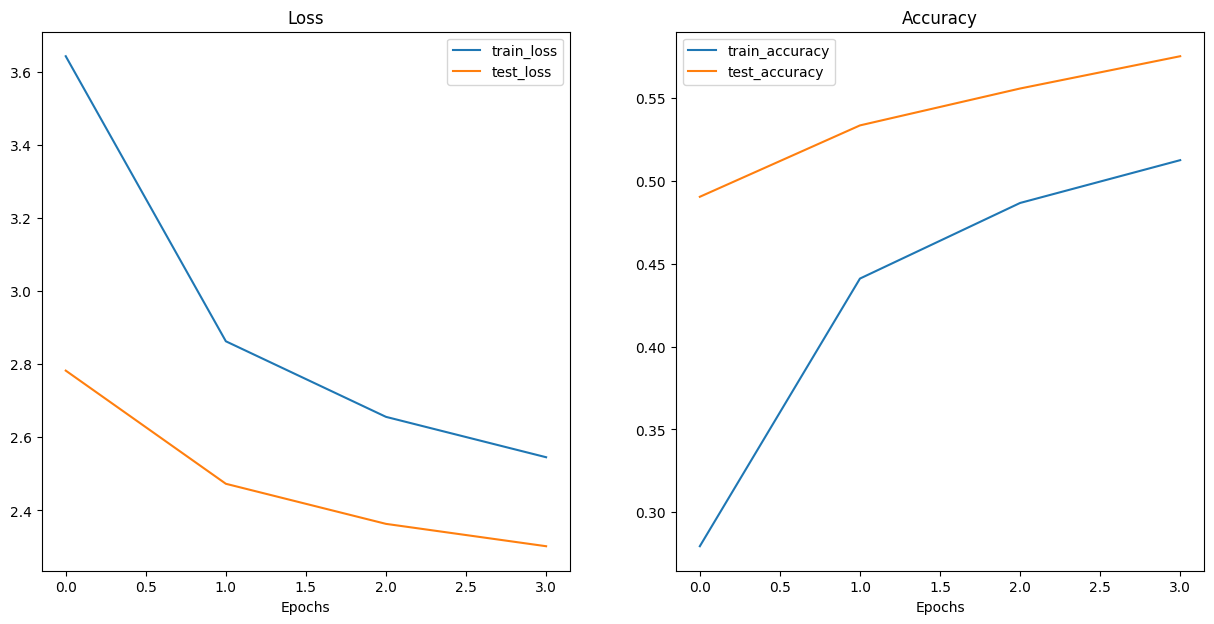

In [158]:
from helper_functions import plot_loss_curves

# Check out the loss curves for FoodVision Big
plot_loss_curves(effnetb2_food101_results)

### 10.7 Saving and loading FoodVision Big

In [159]:
from going_modular.going_modular import utils

# Create a model path
effnetb2_food101_model_path = "09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"

# Save FoodVision Big model
utils.save_model(model=effnetb2_food101,
                 target_dir="models",
                 model_name=effnetb2_food101_model_path)

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth


In [160]:
# Create Food101 compatible EffNetB2 instance
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# Load the saved model's state_dict()
loaded_effnetb2_food101.load_state_dict(torch.load("models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"))

<All keys matched successfully>

### 10.8 Checking FoodVision Big model size

In [161]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_food101_model_size = Path("models", effnetb2_food101_model_path).stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB2 feature extractor Food101 model size: {pretrained_effnetb2_food101_model_size} MB")

Pretrained EffNetB2 feature extractor Food101 model size: 30 MB


# Day 59

## 11. Turning our FoodVision Big model into a deployable app

Why deploy a model?

Deploying a model allows you to see how your model goes in the real-world (the ultimate test set).

Let's create an outline

```
demos/
  foodvision_big/
    09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth
    app.py
    class_names.txt
    examples/
      example_1.jpg
    model.py
    requirements.txt
```

In [162]:
from pathlib import Path

# Create FoodVision Big demo path
foodvision_big_demo_path = Path("demos/foodvision_big/")

# Make FoodVision Big demo directory
foodvision_big_demo_path.mkdir(parents=True, exist_ok=True)

# Make FoodVision Big demo examples directory
(foodvision_big_demo_path / "examples").mkdir(parents=True, exist_ok=True)

### 11.1 Downloading an example image and moving it to the examples directory

In [163]:
# Download and move an example image
!wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
!mv 04-pizza-dad.jpeg demos/foodvision_big/examples/04-pizza-dad.jpg

# Move trained model to FoodVision Big demo folder (will error if model is already moved)
!mv models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth demos/foodvision_big

--2024-07-29 14:56:53--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘04-pizza-dad.jpeg’

04-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.02s   

2024-07-29 14:56:53 (155 MB/s) - ‘04-pizza-dad.jpeg’ saved [2874848/2874848]



### 11.2 Saving Food101 class names to file (`class_names.txt`)

In [164]:
# Check out the first 10 Food101 class names
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [165]:
# Create path to Food101 class names
foodvision_big_class_names_path = foodvision_big_demo_path / "class_names.txt"

# Write Food101 class names list to file
with open(foodvision_big_class_names_path, "w") as f:
    print(f"[INFO] Saving Food101 class names to {foodvision_big_class_names_path}")
    f.write("\n".join(food101_class_names)) # leave a new line between each class

[INFO] Saving Food101 class names to demos/foodvision_big/class_names.txt


In [166]:
# Open Food101 class names file and read each line into a list
with open(foodvision_big_class_names_path, "r") as f:
    food101_class_names_loaded = [food.strip() for food in  f.readlines()]

# View the first 5 class names loaded back in
food101_class_names_loaded[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

### 11.3 Turning our FoodVision Big model into a Python script (model.py)

In [167]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Writing demos/foodvision_big/model.py


### 11.4 Turning our FoodVision Big Gradio app into a Python script (`app.py`)

The `app.py` file will have four mahor parts:
1. Imports and class names setup - for class names, we'll need to import from `class_names.txt` rather thanwith a Python lise
2. Model and transforms preparation  - we'll need to make sure our model is suitable for Foodvision Big
3. Predict function (`predict()`) - this can stay the same as the original `predict()`
4. Gradio app - our Gradio interface + launch command - this will change slighltly from FoodVision Mini to reflect the FoodVision big updates.

In [169]:
%%writefile demos/foodvision_big/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open("class_names.txt", "r") as f: # reading them in from class_names.txt
    class_names = [food_name.strip() for food_name in  f.readlines()]

### 2. Model and transforms preparation ###

# Create model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=101, # could also use len(class_names)
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Big 🍔👁"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food."
article = "Created by Nabin Yadav."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create Gradio interface
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=5, label="Predictions"),
        gr.Number(label="Prediction time (s)"),
    ],
    examples=example_list,
    title=title,
    description=description,
    article=article,
)

# Launch the app!
demo.launch()

Overwriting demos/foodvision_big/app.py


### 11.5 Creating a requirements file for FoodVision Big (requirements.txt)

In [171]:
import gradio

In [177]:
%%writefile demos/foodvision_big/requirements.txt
torch==2.3.1
torchvision==0.18.1
gradio==4.39.0

Writing demos/foodvision_big/requirements.txt


In [176]:
torchvision.__version__

'0.18.1+cu121'

### 11.6 Downloading our FoodVision Big app files

In [178]:
# Zip foodvision_big folder but exclude certain files
!cd demos/foodvision_big && zip -r ../foodvision_big.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Big app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/foodvision_big.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download()")

  adding: 09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth (deflated 8%)
  adding: app.py (deflated 55%)
  adding: class_names.txt (deflated 48%)
  adding: examples/ (stored 0%)
  adding: examples/04-pizza-dad.jpg (deflated 0%)
  adding: model.py (deflated 56%)
  adding: requirements.txt (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 11.7 Deploying our FoodVision Big app to HuggingFace Spaces

Successfully deployed foodvision big model to HuggingFace!!!

Link:
https://huggingface.co/spaces/nabinyd/foodvision_big